In [1]:
pwd

'/data2/mito_lineage/Analysis/multiplex'

In [2]:
INDIR="data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse"
OUTDIR= "data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3"
N_DONORS=4 


In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

fig_utils from mplh
here
0.4.2


In [4]:
def filt_high(df, thresh):
    return df.loc[(df.mean(axis=1)<thresh)].index.values


# Using vireo for clonal reconstruction - mitochondrial mutations

The mitochondrial mutations data set is extracted from [Ludwig et al, Cell, 2019](https://doi.org/10.1016/j.cell.2019.01.022), the 9 variants used here are from Supp Fig. 2F (and main Fig. 2F).

For clonal reconstruction, we are using the core class `vireoSNP.Vireo` with multiple initializations

## Load cluster results and test for enrichment

data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster0.DP.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster1.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster1.DP.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster2.DP.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster3.AD.txt
data/jan21_2021/chrM/pseudo/minC200_minAF0.01/numC25000_ispropFalse/flt3/cluster3.DP.txt


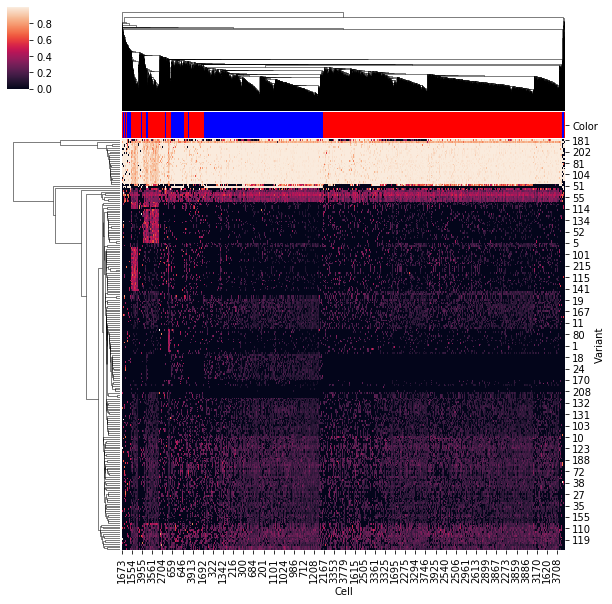

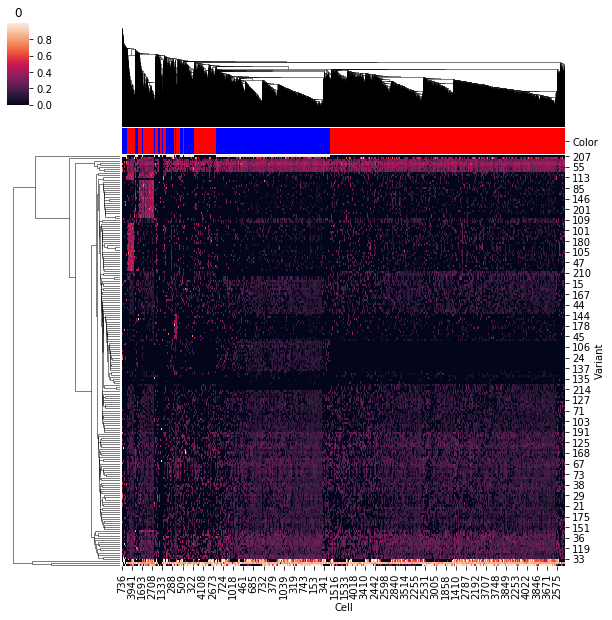

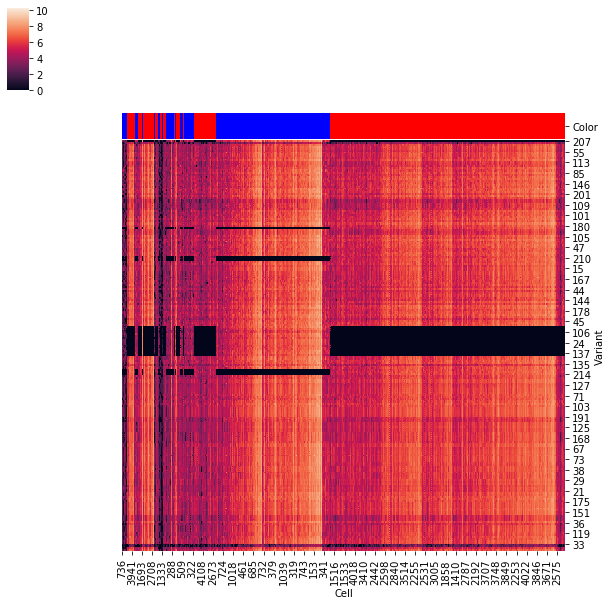

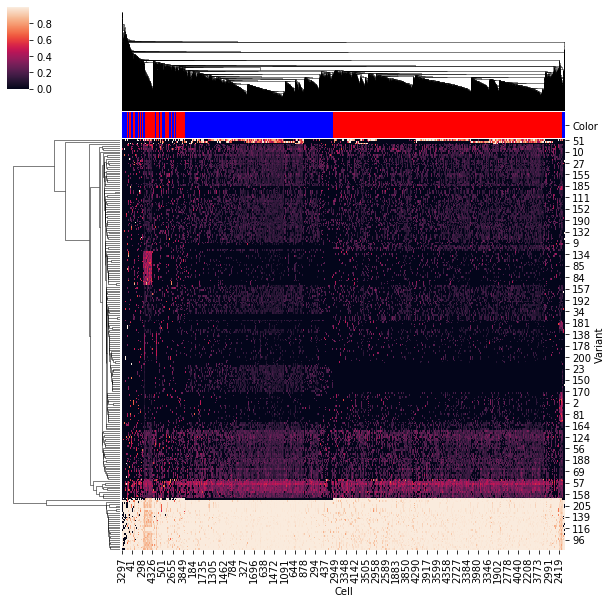

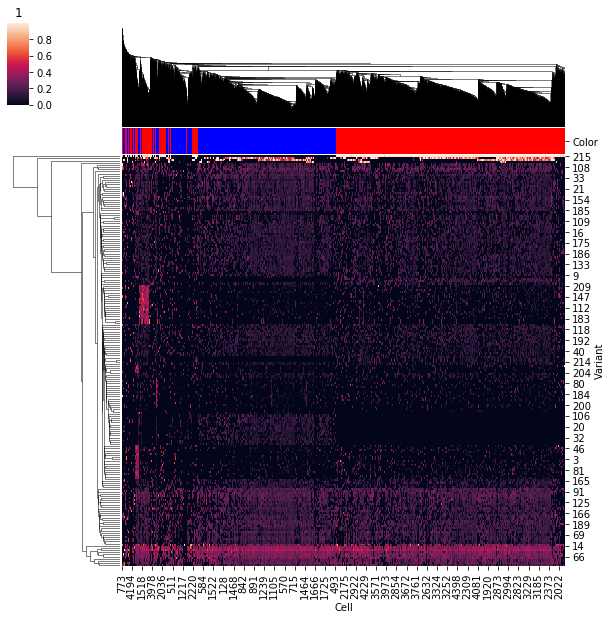

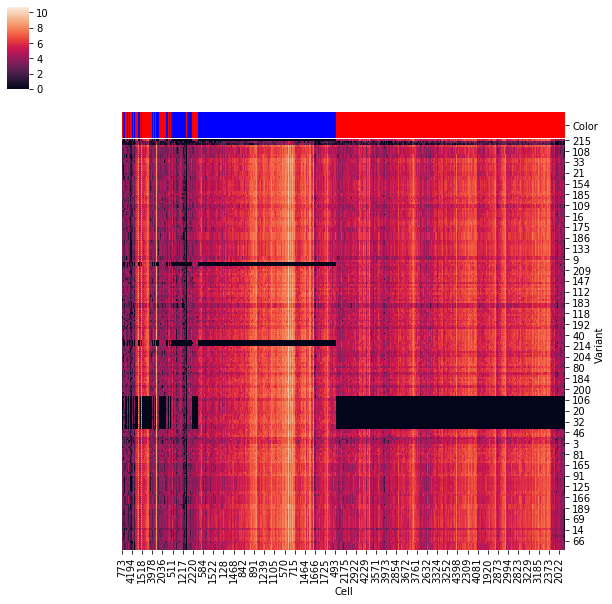

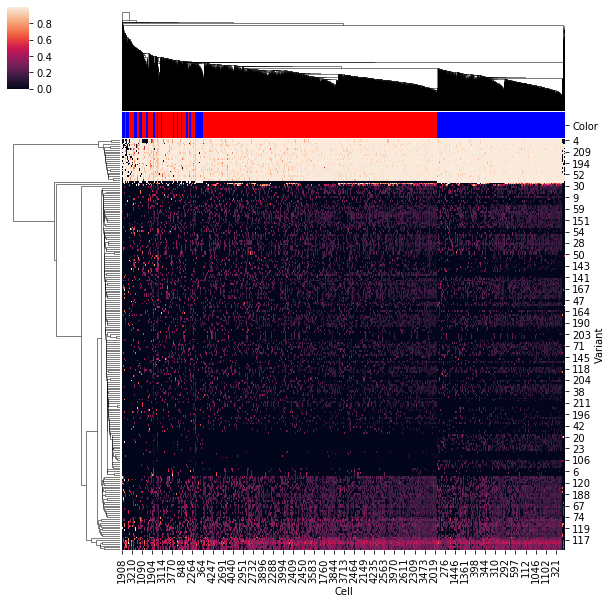

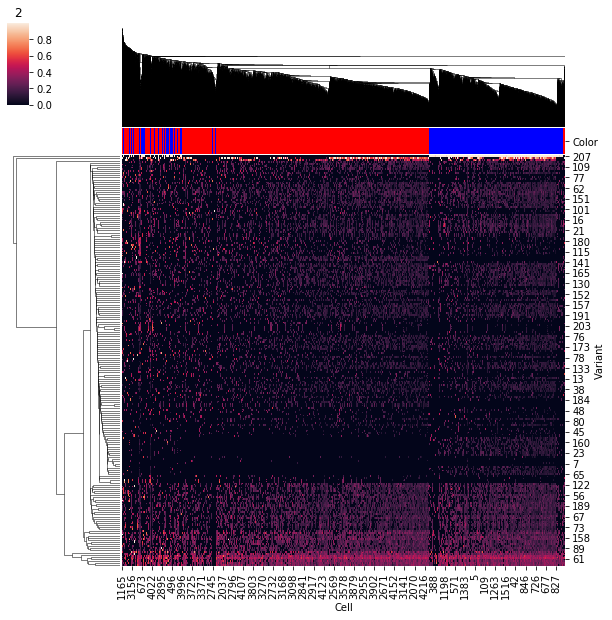

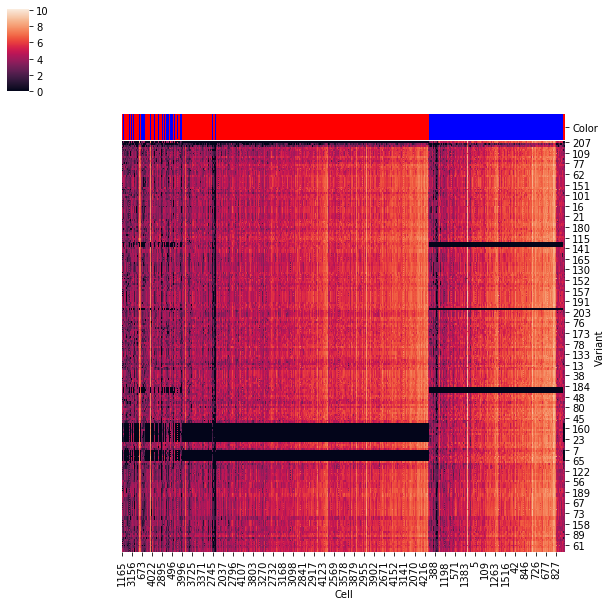

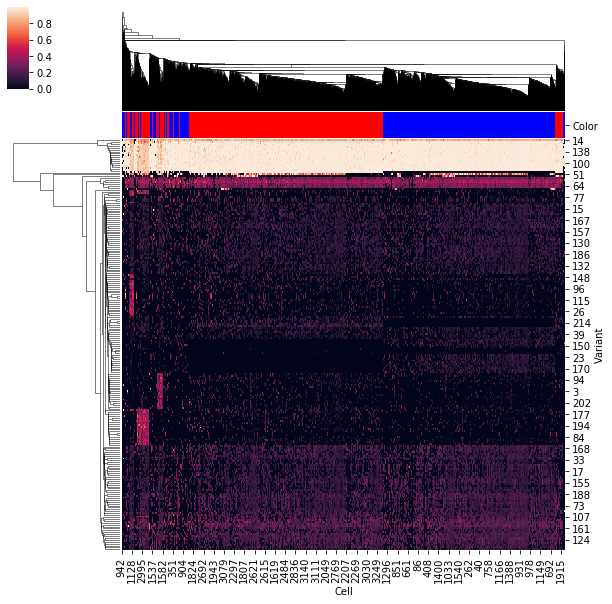

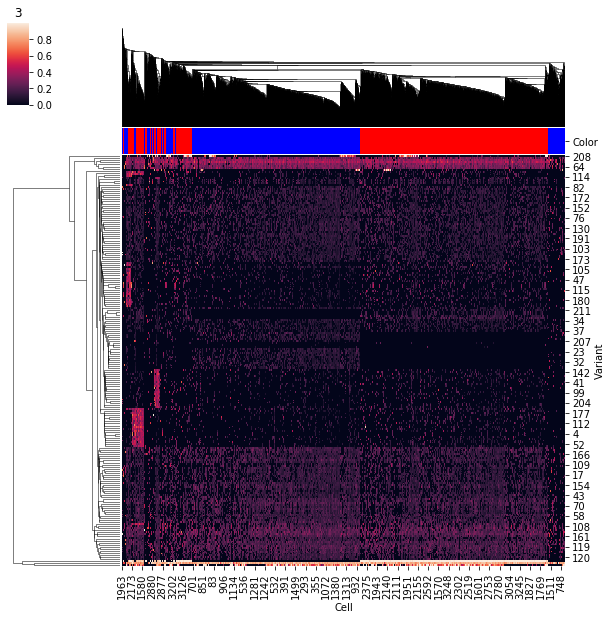

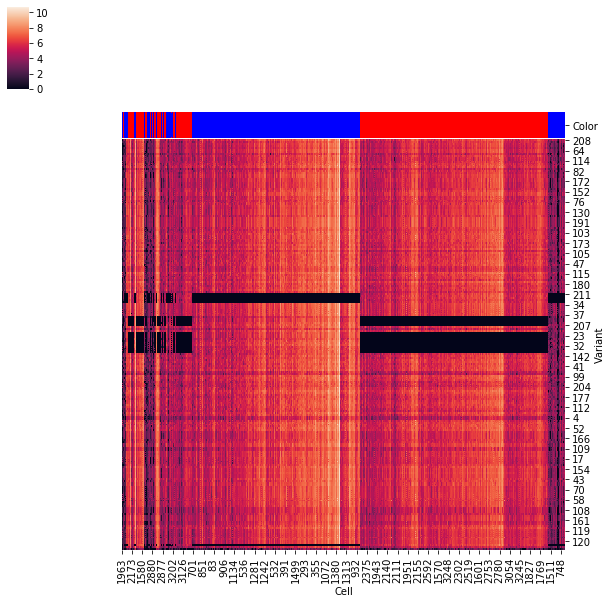

In [7]:
n_clone_list = [7]#[2,3,4,5,6,7]

for n in range(N_DONORS):
    curr_ad_f = join(OUTDIR, f"cluster{n}.AD.txt")
    curr_dp_f = join(OUTDIR, f"cluster{n}.DP.txt")
    print(curr_ad_f)
    print(curr_dp_f)
    curr_ad = mmread(curr_ad_f).tocsc()
    curr_dp = mmread(curr_dp_f).tocsc()
    AD_df = pd.DataFrame(curr_ad.todense())
    DP_df = pd.DataFrame(curr_dp.todense())
    DP_df.index.name = "Variant"
    DP_df.columns.name = "Cell"
    AD_df.index.name = "Variant"
    AD_df.columns.name = "Cell"
    AF_df = AD_df/(DP_df+0.001)
    #AD_df = pd.merge(AD_df, vcf[["#CHROM", "POS", "ALT"]], how="inner", left_index=True,right_index=True).set_index(["#CHROM", "POS", "ALT"])
    curr_labels = pd.read_csv(join(OUTDIR, f"cluster{n}.labels.txt"), index_col=0)
    out_f = join(OUTDIR, f"cluster{n}_dendrogram.png")
    
    #cols=np.random.choice(AF_df.columns,size=500, replace=False)
#     cols = AF_df.columns
    
#     #f, ax = plt.subplots(nrows=2, ncols=1)
#     raw_af = AF_df.copy()
#     AF_df = AF_df.loc[:,cols]
#     DP_df = DP_df.loc[:,cols]
#     curr_labels = curr_labels.loc[cols]
    curr_labels["Color"] = curr_labels["sample ID"].map({"Control": "Blue", "Flt3": "Red"})
    g = sns.clustermap(np.sqrt(AF_df), col_colors=curr_labels[["Color"]], row_cluster=True, col_cluster=True)
    plt.savefig(out_f+".withHigh.png")
    
    
    cols2 = filt_high(AF_df, thresh=0.9)
    AF_df = AF_df.loc[cols2]
    DP_df = DP_df.loc[cols2]
    #curr_labels = curr_labels.loc[cols2]
    
    
    g = sns.clustermap(np.sqrt(AF_df), col_colors=curr_labels[["Color"]], row_cluster=True, col_cluster=True)
    plt.title(f"{n}")
    plt.savefig(out_f)
    
    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]

    #inds = AF_df.sum(axis=1).sort_values().index.values
    sns.clustermap(np.log2(DP_df.iloc[inds, cols]+1), row_cluster=False, col_cluster=False, 
                  col_colors=curr_labels.iloc[cols][["Color"]])
#     sns.clustermap(np.log2(AD_df.iloc[inds, cols]+1), col_colors=curr_labels.iloc[inds][["Color"]].reset_index(drop=True),
#                    row_cluster=False, col_cluster=False)
    plt.savefig(out_f+".depth.png")